# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Running our code is pretty straightforward. The comments will explicitely state what to do further down wherever human input is required. For running our code, you'll need sklearn, matplotlib, seaborn, pandas,numpy, random and re which are commonly used libraries which you will probably have installed. Lastly, the only data you'll need is what was initially provided to us all on brightspace. 


### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
from random import randint
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.pipeline import make_pipeline

### Reading in the Data (The one provided to us in brightspace.)

In [2]:
data = "data_for_student_case.csv" #Provide the path to the data here.
df_OG = pd.read_csv(data)

### Preprocessing 

In [3]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    # Here we simply remove the refuse class from our dataframe.
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    
    #3-6 is made to be 3 for cvcresponsecode variable.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc = LabelEncoder()
    enc.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc.transform(df1.txvariantcode)

    enc = LabelEncoder()
    enc.fit(df1['currencycode'])
    df1['currencycode'] = enc.transform(df1.currencycode)

    enc = LabelEncoder()
    enc.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc.transform(df1.shopperinteraction)

    enc = LabelEncoder()
    enc.fit(df1['accountcode'])
    df1['accountcode'] = enc.transform(df1.accountcode)

    enc = LabelEncoder()
    enc.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc.transform(df1.cardverificationcodesupplied)
    
    enc = LabelEncoder()
    enc.fit(df1['mail_id'])
    df1['mail_id'] = enc.transform(df1.mail_id)

    
    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    #Converting creation and booking date to datestamps.
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])
    
    #Obtaining the day of week and hour of transactions using date timestamps. 
    df1['date'] = df1['creationdate'].dt.date 
    df1['day_of_week'] = df1['creationdate'].dt.dayofweek
    df1['hour'] = df1['creationdate'].dt.hour
    
    #converting creation date to unix_timestap.
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    #Standardizing amount to a single currency.
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    #df1 = df1.loc[~((df1['simple_journal'] == 0)&(df1['amount_eur']>320))]
    return df1
# Pre-processing the dataframe.
df1=preprocess(df_OG)

### Transaction Class distributions.

In [4]:
print("Number of total data points = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 0])))  

Number of total data points = 237036
Number of fradulent transactions = 345
Number of valid transactions = 236691


## 1. Visualization task 

#### I) Account Code and Number of Fraud

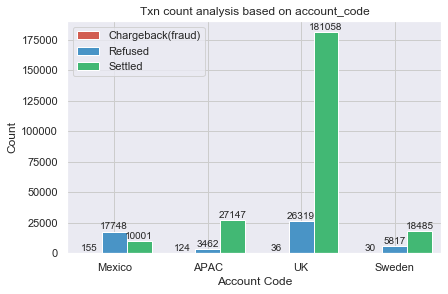

In [16]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df_OG, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
ax.set(xticklabels=["Mexico","APAC","UK","Sweden"])
ax.legend(["Chargeback(fraud)","Refused", "Settled"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=10)

**Description** - Based on this barchart, we see that there is an uneven distribution between fraudulent and non-fraudulent cases. Firstly, in general the fraud cases are in stark minority to the non-fraud cases. Secondly the uneven distribution (in terms of transactions) also plagues the data based on different accounts in our dataset, geographically. We observe that the majority of fraud cases originate from Mexico based accounts even though majority (number of) transactions have occured from UK based accounts. 

#### II) Amount in Euros Distribution for Fraud vs Normal

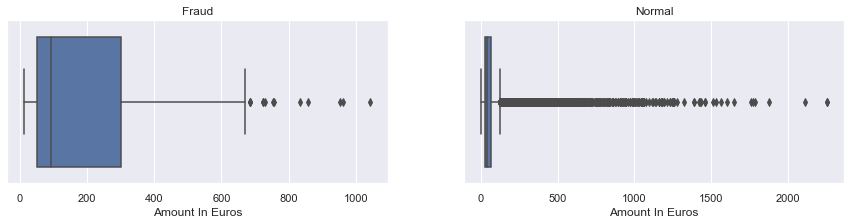

In [6]:
df_f = df1.loc[df1.simple_journal==1]
df_nf = df1.loc[df1.simple_journal==0]
nf_amt=df_nf.amount_eur.values
f_amt=df_f.amount_eur.values 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 3))
sns.boxplot(f_amt,ax=ax1)
ax1.set_title('Fraud')
sns.boxplot(nf_amt,ax=ax2)
ax2.set_title('Normal')
ax2.set_xlabel("Amount In Euros")
ax1.set_xlabel("Amount In Euros")
plt.show()

**Description** - From these boxplots, we observe that fraudulent transactions have a wider inter-quartile range than non-fraudulent cases with respect to amount in euros spent, per transaction (EUR/transaction). Additionally, the distribution of amount in euros for fraudulent transactions generally seems to be higher than non-fraudlent cases as indicated by the two medians. However, we need to keep in mind that there are many outliers for the 'non-fraudulent' transactions. 

#### III) Temporal relationship between Currency_code and number of fraudulent transactions

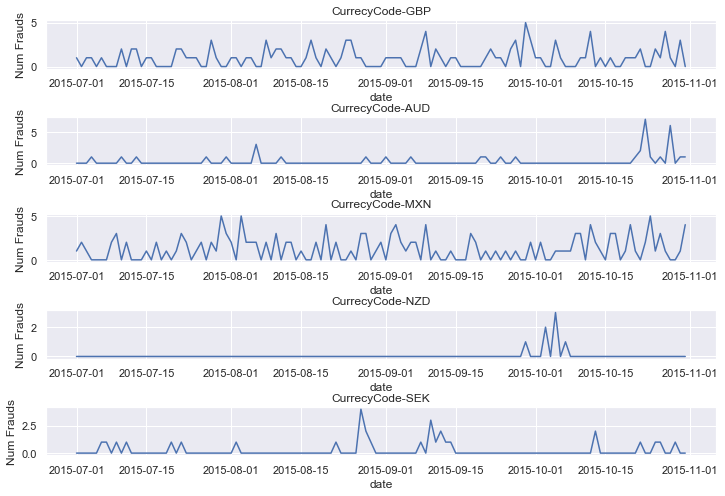

In [7]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['date','simple_journal']].groupby(['date']).sum()
df_AUD = df_AUD[['date','simple_journal']].groupby(['date']).sum()
df_MXN = df_MXN[['date','simple_journal']].groupby(['date']).sum()
df_NZD = df_NZD[['date','simple_journal']].groupby(['date']).sum()
df_SEK = df_SEK[['date','simple_journal']].groupby(['date']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(12, 8))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

**Description** - Based on the temporal lineplots above, we see that fraudulent transactions happen more frequently for the GBP and MXN currency codes. Secondly, we do not see any significant overlaps between dates, especially for the dates on which most currency codes show high number of fraud cases! This clearly suggests that date is not a common denominator when it comes to analysing fraudulent transactions.

#### IV) Difference in mean amount in euros with respect to cvcresponse code for fraud and non fraud cases.

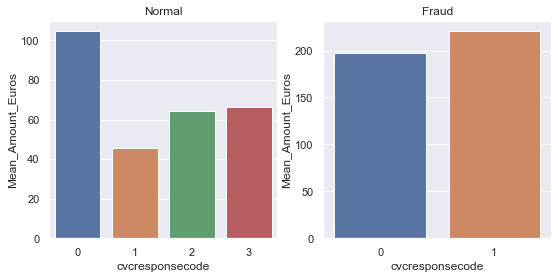

In [8]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[df1["simple_journal"]==0]
df5 = dff[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
df6 = df_nf[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")

plt.show()

**Description** - Based on the barcharts shown above we can see that for normal transactions, the mean amount in euros is higher for a cvcresponsecode of *0* which corresponds to a case where the presence/absence of the CVC/CVV2 code was *unknown* or not recorded. However, for fraud cases, the mean amount in euros is higher for a cvcresponsecode of *1* which corresponds to a case where the CVC/CVV2 code was entered correctly (i.e. match). We believe this is indicative of fact that fraudsters were good at disguising their transactions making them seem close to real ones (non-fraudulent txns). We also note that the mean amount in euros is actually much higher for fraudulent cases than for non-fraudulent transactions. This can be supported with respect to the boxplots we discussed previously.

#### V) Percentage fraud cases associated with cvcresponsecode for local vs international transactions

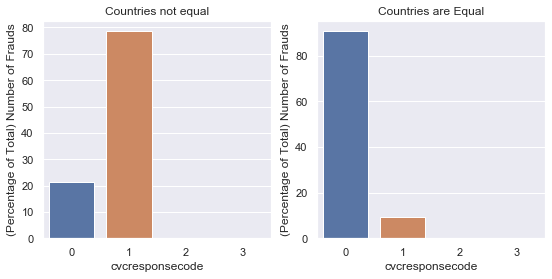

In [9]:
dff= df1.loc[df1["countries_equal"]==1]
df_nf=df1.loc[df1["countries_equal"]==0]
df5 = dff[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df5["simple_journal"].sum()
df5["simple_journal"]=(df5["simple_journal"]/total)*100
df6 = df_nf[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df6["simple_journal"].sum()
df6["simple_journal"]=(df6["simple_journal"]/total)*100
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['simple_journal'],ax=ax2)
ax2.set(ylabel = "(Percentage of Total) Number of Frauds")
ax2.set_title("Countries are Equal")
sns.barplot(x=df6.index,y=df6['simple_journal'],ax=ax1)
ax1.set(ylabel = "(Percentage of Total) Number of Frauds")
ax1.set_title("Countries not equal")
plt.show()

**Description** - Based on the barcharts shown above we can see that for international transactions (i.e. transactions with currencycode different than the accountissuercountrycode), the percentage of fraud cases with a cvcresponsecode of 1 is higher whereas for local transactions, the cvcresponsecode with a value of 0 is the majority. It can be concluded that the fraudulent transactions conducted in a currency other than the one associated with the  account (we're calling it an international *fraud* transaction), usually had the correct CVC/CVV2 code. This was not necessarily the case (as observed) with local *fraud* transactions!

#### VI) Issuercountrycode and mean amount in euros for fraud vs normal transactions.

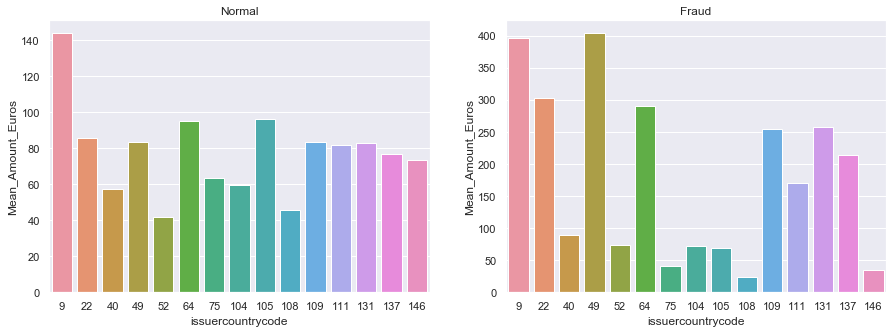

In [10]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["issuercountrycode"].isin([9,22,40,49,52,64,75,104,105,108,109,111,131,137,146]))]
df5 = dff[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
df6 = df_nf[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 5))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

**Description**- Based on this barchart of *mean-amount vs issuercountrycode*, we observe that fraudulent transactions actually have a higher mean amount (expenditure) in most countries when compared to normal (non-fraudulent) transactions. We additionally see that the distribution of expenditure for different countries is not homogenous; with the highest amount in euros (mean) for fraudulent transcations occuring in issuer_country_codes 49 and 9 which is not necessrily same for normal (non-fraudulent) transactions.

#### VII) TxVariant and Mean Amount in Euros for normal and fraud cases

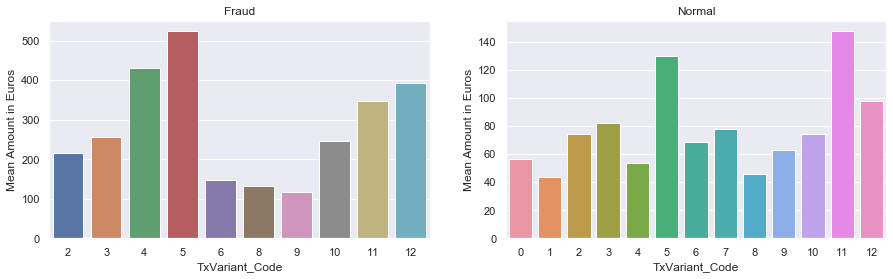

In [11]:
df2 = df1.loc[df1["simple_journal"]==1][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 4))
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean Amount in Euros")
ax1.set_xlabel('TxVariant_Code')
ax1.set_title("Fraud")
df2 = df1.loc[df1["simple_journal"]==0][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
sns.set(style="whitegrid")
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean Amount in Euros")
ax2.set_xlabel('TxVariant_Code')
ax2.set_title("Normal")
plt.show()

**Description** - The barchart plotting *Mean amount vs the TxnVariant_Code*, allows us to showcase a comparison between mean amount (in euros) for different txvariant_codes (codes are indicative of the brand/sub-brand of credit-card being used). Just like in previous visualisation, we see a common trend that mean amount in euros is usually higher in case of fraudulent transactions. We observe that the TxVariant_codes 5 and 4 have the highest mean amount (in euros) per fraudulent transaction. 

## 2. Imbalance task – Anwesh
### SMOTE implementation with optional tomek link removal
Following is the implementation of Synthetic Minority Over-sampling Technique with optional Tomek link removal.

In [5]:
import random
import math

# for tomek links implementation
from sklearn.neighbors import NearestNeighbors

'''
Function to find the k nearest neighbours
'''
def k_neighbors(curr_row, data, k):
    dist_list = list()
    for idx in range(len(data)):
        dist = euclidean_distance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
    for i in range(k):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours
    
'''
Calculate the Euclidean distance between two vectors
'''
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

'''
SMOTE function:
    T => Number of minority Samples available
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    returns a list of synthetic samples
'''
def smote(T,N,k,minority_samples):
    
# if N < 100, sample from random percent of minority instances
    if N < 100:
        T = (N/100) * T
        N = 100 # since we changed T now, make N = 100
        
# N controls the number of synthetic samples generated per data point
    N = (int)(N/100)
    synthetic_samples = list()
    
    for i in range(T):
        counter = N
# If k = 0, the nearest neighbour is the point itself.
        if(k):
            nn_list = k_neighbors(minority_samples[i], minority_samples, k)
        else:
            rand_knbr = i
        while counter:
            rand_nn = random.randint(1, len(nn_list) - 1)
            rand_knbr = nn_list[rand_nn]
            sample_row = []
            for attr in range(len(minority_samples[i])):
                diff = minority_samples[rand_knbr][attr] - minority_samples[i][attr]
                rand_gap = random.uniform(0, 1)
                sample_row.append(int(minority_samples[i][attr] + rand_gap*diff))
            synthetic_samples.append    
            synthetic_samples.append(sample_row)
            counter = counter - 1
    
    return synthetic_samples

'''
Wrapper for the SMOTE function:
default tomek_link = False (links are not removed)
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    tomek_links => True: remove tomek_links, False: do not remove
'''
def smote_wrapper(df1, N, k, tomek_links = False):
# Drop these columns from the parent df
    prep_df = df1.copy()
    
# Separate out the fraud and non-fraud instances
    not_fraud_df = prep_df.loc[prep_df["simple_journal"] == 0]
    fraud_df = prep_df.loc[prep_df['simple_journal'] == 1]
    minority_samples = np.array(fraud_df)
    cols = prep_df.columns
# Generate 'N%' new synthetic samples condsidering 'k' nearest neighbours
    synthetic_fraud_df = pd.DataFrame(smote(len(minority_samples), N, k, minority_samples),
                                      columns=cols)  
    
    aug_fraud_df = pd.concat([fraud_df, synthetic_fraud_df])
    full_df = pd.concat([aug_fraud_df, not_fraud_df])
    
    
# Tomek Links
    len_fraud = len(aug_fraud_df.values)
    if(tomek_links):
        remove_idx=[]
        full_df_mat = full_df.values
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(full_df_mat)
        distances, indices = nbrs.kneighbors(full_df_mat[:len_fraud])
        for i in indices:
            if i[1] > len_fraud:
                remove_idx.append(i[0])
        needed = list(set(np.arange(len_fraud)) - set(remove_idx))
        aug_fraud_df = pd.DataFrame([aug_fraud_df.iloc[i] for i in needed])
        full_df = pd.concat([aug_fraud_df, not_fraud_df])
        
#     full_df['amount_eur'] = full_df.apply(lambda x: conv(x), axis=1)
    return full_df

### Function to Undersample majority class
Majority class is undersampled to have a distribution -> num(majority_samples) = (p/100) * num(minority_samples), where p is the percent value provided.

In [6]:
from sklearn.utils import resample

def downsample_majority_class(df1, percent):
    df = df1.copy()
    
    not_fraud_df = df.loc[df["simple_journal"] == 0]
    fraud_df = df.loc[df['simple_journal'] == 1]
    if(percent):
        num_samples = int(len(fraud_df) * (100/percent))
    else:
        num_samples = len(fraud_df)
    not_fraud_downsampled = resample(not_fraud_df,
                                    replace = False, # sample without replacement
                                    n_samples = num_samples, # match minority n
                                    random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_fraud_downsampled, fraud_df])
    
    return downsampled

### Apply SMOTE and Undersampling to the data

In [7]:
from sklearn.preprocessing import StandardScaler
y = df1.drop(['txid', 'bookingdate', 'date', 'creationdate'], axis=1)['simple_journal']
X = df1.drop(['txid', 'bookingdate', 'date', 'creationdate'], axis=1)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=3)

# We will Smote the X_train data
# 500% or 5 times the minority samples with 2 nearest neighbours
# Tomek Links not removed if tomek_links is set to false
smoted_df = smote_wrapper(x_train, N = 500, k = 2, tomek_links = False)

# undersampling will have 'percent' amount of samples of the majority class.
# 50% implies -> count(minority samples) = 0.5 * count(majority samples)
smoted_df = downsample_majority_class(smoted_df, percent=20)
print(smoted_df['simple_journal'].value_counts())

# drop the labels from the training and testing data
x_train = x_train.drop(['simple_journal'], axis=1)
x_test = x_test.drop(['simple_journal'], axis=1)

unsmote_scaler = StandardScaler().fit(x_train)
X_train = unsmote_scaler.transform(x_train)
X_test = unsmote_scaler.transform(x_test)

0    7230
1    1446
Name: simple_journal, dtype: int64


**NOTE**
1. We first split the data into train and test (70/30)
2. Apply Smote and undersample the **training data** into a 'smoted_df', keeping testing data separate
3. We will then compare the performance of the Normal (Unsmoted Data) vs this smoted_df on this untouched **test data**
4. We scale the features of train and test data using **StandardScaler**, fitted on the training-data after making the train-test split.

We visualize the difference in the data distribution using a couple of scatter-plots as follows:

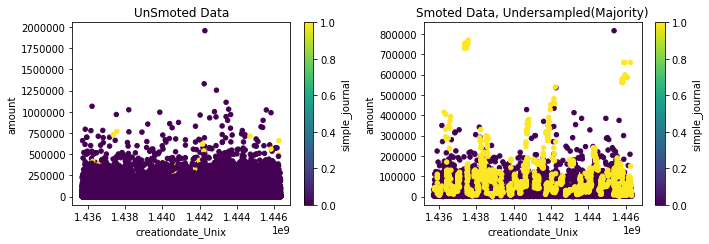

In [8]:
# Scatter Plots to visualize the SMOTE results
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
df1.reset_index().plot.scatter(x='creationdate_Unix', y='amount', c='simple_journal', colormap='viridis',
                               ax=ax, title='UnSmoted Data')
smoted_df.reset_index().plot.scatter(x='creationdate_Unix', y='amount', c='simple_journal', colormap='viridis', 
                                     ax=ax2, title='Smoted Data, Undersampled(Majority)')
fig.tight_layout()

### 2a. To SMOTE or not to SMOTE?
In order to begin this discussion, we train three classifiers to help understand what SMOTE'ing the data does to our 
classification performance. We discuss the results in a later section!

_Applying the following classifiers on Smoted Data & UnSmoted Data._
#### 1. Naive Bayes Classifier

In [9]:
# Original unsmoted data
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("NB on UnSmoted data: Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("Naive Bayes Accuracy (unsmoted): %.2f" %(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
y_test_nb_unsmoted = y_test

# Smoted data
y_train_smoted = smoted_df['simple_journal']
smoted_df = smoted_df.drop(['simple_journal'], axis=1)
smote_scaler = StandardScaler().fit(smoted_df)
X_train_smoted = smote_scaler.transform(smoted_df)
# X_test_smoted is the same test-set which is just scaled differently, using the transform from X_train_smoted
X_test_smoted = smote_scaler.transform(x_test)

gnb_smote = GaussianNB()
y_pred_smote = gnb_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)
print("NB on smoted data: Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred_smote).sum()))
print("Naive Bayes Accuracy (Smoted): %.2f" %(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = gnb_smote.predict_proba(X_test_smoted)[::,1]
fpr_smote, tpr_smote, thresholds_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


NB on UnSmoted data: Number of mislabeled points out of a total 71111 points : 2975
Naive Bayes Accuracy (unsmoted): 95.82
NB on smoted data: Number of mislabeled points out of a total 71111 points : 12334
Naive Bayes Accuracy (Smoted): 82.66


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


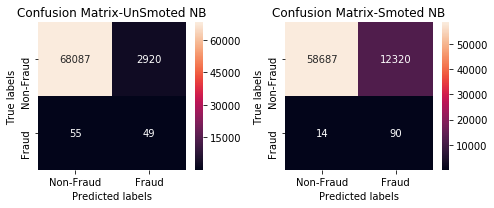

In [10]:
from sklearn.metrics import confusion_matrix

nb_unsmoted_cm = confusion_matrix(y_test_nb_unsmoted, y_pred)
nb_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
# ax = fig_1.add_subplot()
sns.heatmap(nb_unsmoted_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

# fig_2 = plt.figure(2)  
# ax = fig_2.add_subplot()
sns.heatmap(nb_smoted_cm, annot=True, ax = ax2, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted NB')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### 2. Logistic Classifier

In [13]:
# Original unsmoted data
# Max iters allows to converge
logistic_clf = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
y_pred = logistic_clf.fit(X_train, y_train).predict(X_test)

print("LogisticClassifier on UnSmoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("LogisticClassifier Accuracy (UnSmoted): %.2f "%(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = logistic_clf.predict_proba(X_test)[::,1]
fpr_lc, tpr_lc, thresholds_lc = metrics.roc_curve(y_test, y_pred_proba)
auc_lc = metrics.roc_auc_score(y_test, y_pred_proba)

# SMOTED
logistic_clf_smote = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
y_pred_smote = logistic_clf_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)

print("LogisticClassifier on smoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred_smote).sum()))
print("LogisticClassifier Accuracy: %.2f "%(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = logistic_clf_smote.predict_proba(X_test_smoted)[::,1]
fpr_lc_smote, tpr_lc_smote, thresholds_lc_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_lc_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


LogisticClassifier on UnSmoted data: mislabeled points out of a total 71111 points : 109
LogisticClassifier Accuracy (UnSmoted): 99.85 
LogisticClassifier on smoted data: mislabeled points out of a total 71111 points : 2938
LogisticClassifier Accuracy: 95.87 


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


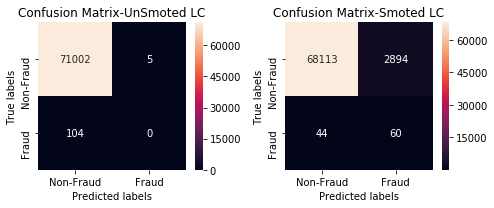

In [14]:
from sklearn.metrics import confusion_matrix

lc_unsmoted_cm = confusion_matrix(y_test, y_pred)
lc_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
# ax = fig_1.add_subplot()
sns.heatmap(lc_unsmoted_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted LC')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

# fig_2 = plt.figure(2)  
# ax = fig_2.add_subplot()
sns.heatmap(lc_smoted_cm, annot=True, ax = ax2, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted LC')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### 3. Random Forest Classifier

In [16]:
# Original unsmoted data
# WARNING: RF might take a bit of time to process, reduce n_estimators to a lesser value
# n_estimators = 100 -> 100 trees generated for RF classification

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred = rf_clf.fit(X_train, y_train).predict(X_test)

print("RF on UnSmoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("RF Accuracy (UnSmoted): %.2f "%(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = rf_clf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_proba)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba)

# SMOTED
rf_clf_smote = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred_smote = rf_clf_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)

print("RF on smoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred_smote).sum()))
print("RF Accuracy: %.2f "%(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = rf_clf_smote.predict_proba(X_test_smoted)[::,1]
fpr_rf_smote, tpr_rf_smote, thresholds_rf_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_rf_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


RF on UnSmoted data: mislabeled points out of a total 71111 points : 98
RF Accuracy (UnSmoted): 99.86 
RF on smoted data: mislabeled points out of a total 71111 points : 1002
RF Accuracy: 98.59 


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


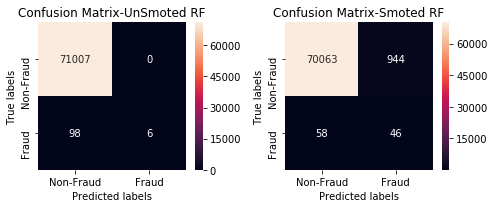

In [17]:
from sklearn.metrics import confusion_matrix

rf_unsmoted_cm = confusion_matrix(y_test, y_pred)
rf_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
# ax = fig_1.add_subplot()
sns.heatmap(rf_unsmoted_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted RF')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

# fig_2 = plt.figure(2)  
# ax = fig_2.add_subplot()
sns.heatmap(rf_smoted_cm, annot=True, ax = ax2, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted RF')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### ROC Curves

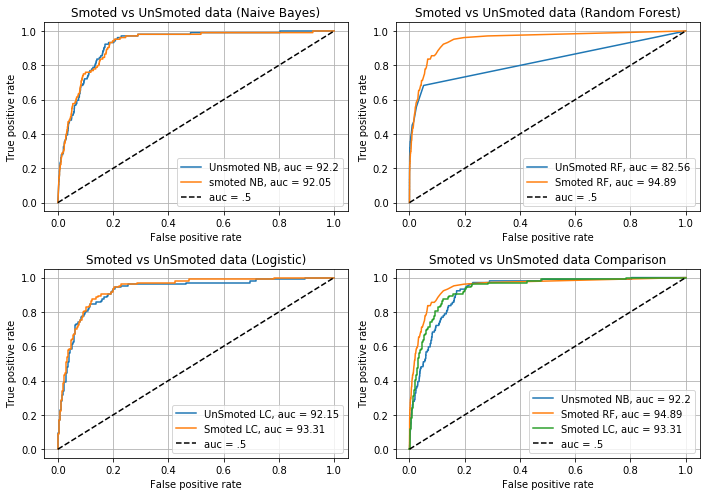

In [47]:
# AUC curve

fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))


ax.plot(fpr, tpr, label="Unsmoted NB, auc = " +str(round(auc*100,2)))
ax.plot(fpr_smote, tpr_smote, label = "smoted NB, auc = "+str(round(auc_smote*100,2)))
ax.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title("Smoted vs UnSmoted data (Naive Bayes)")
ax.legend(loc=4)
ax.grid()

# AUC curve for RF

ax1.plot(fpr_rf, tpr_rf, label = "UnSmoted RF, auc = "+str(round(auc_rf*100,2)))
ax1.plot(fpr_rf_smote, tpr_rf_smote, label="Smoted RF, auc = " +str(round(auc_rf_smote*100,2)))
ax1.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title("Smoted vs UnSmoted data (Random Forest)")
ax1.legend(loc=4)
ax1.grid()

# AUC curve for LC

ax2.plot(fpr_lc, tpr_lc, label = "UnSmoted LC, auc = "+str(round(auc_lc*100,2)))
ax2.plot(fpr_lc_smote, tpr_lc_smote, label="Smoted LC, auc = " +str(round(auc_lc_smote*100,2)))
ax2.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title("Smoted vs UnSmoted data (Logistic)")
ax2.legend(loc=4)
ax2.grid()


# AUC curve for ALL

ax3.plot(fpr, tpr, label="Unsmoted NB, auc = " +str(round(auc * 100,2)))
ax3.plot(fpr_rf_smote, tpr_rf_smote, label="Smoted RF, auc = " +str(round(auc_rf_smote * 100,2)))
ax3.plot(fpr_lc_smote, tpr_lc_smote, label="Smoted LC, auc = " +str(round(auc_lc_smote * 100,2)))
ax3.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax3.set_xlabel('False positive rate')
ax3.set_ylabel('True positive rate')
ax3.set_title("Smoted vs UnSmoted data Comparison")
ax3.legend(loc=4)
ax3.grid()


fig.tight_layout()
plt.show()

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

**'Best Performance'** is not a straightforward target to chase in this scenario due to the inherent data imbalance. The accuracy alone, for example, provides a poor evaluation of the model especially in case of **unsmoted data**, as is apparent from the confusion matrices (for unsmoted data) eventhough the accuracy is generally good i.e. in the early _90 percents_ on average. It is hence understood that high accuracy scores for the given data do not translate into good classification-per-class; all three classifiers, show poor classification for the fraudulent cases which are in minority and end up getting classsified in the majority (non-fradulent) class while being able to uphold the high accuracy values. _For example:_ The Random Forest Classifier outputs a **_99.86%_** accuracy (face-value) but on looking under the hood at the classification performance per-class (using confusion-matrices and ROC curves) it is only able to classify (6/104) fraudulent samples from the test set, showing a measly **_5%_** accuracy in identifying fradulent cases! The performance for the non-fraud (majority-class) case is expectedly higher.

It is hence imperative to analyse the **ROC-curves** which highlight the distinguishing power of a classifier by varying the discrimination threshold for this binary classification scenario. In order to understand the performance of the classifier for this task, is important to look at the trade-off between generating False-Positives (Non-Fraudulent txns classified as Fraudulent txns). To realise, compare the confusion matrices for these classifiers... one can see that while Naive-Bayes has the highest accuracy for fradulent cases **(90/104)**, it comes at the cost of **_12,206_ false-positives**! **~10x** greater than the observed false-positives for the Logistic or the Random-Forest classifier! Trying to reduce the no. of false positives, brings us back to the situation where our classifier is unable to identify the fradulent txns (the results are aggravated in case of UnSmoted data). 

#### ROC Curves: WIP

Hence, we are of the opinion that we need to strike a balance in being able to distinguish fraudulent txns (which is the minority class) while keeping the False-Positive Rate (fpr: x-axis for the ROC) manageable. It might eventually depend on the cost of filtering through each transaction. For example, In case this cost is very resource intensive, having a low FPR might be preferable over being able to catch all the fraudulent cases.

Based on this discussion and our obtained results, we suggest using the **Logistic classifier on SMOTE'd data**. With a minority-class accuracy of **_~58%_** and **_2,885_** False-Positives, it seems to strike a balance between the high FPR seen in the Naive Bayes implementation and the relatively less classsification performance for fraudulent-txns observed in the Random-Forest Classifier. 

**Addendum:** It might be preferable to use Random forests as well (in certain cases where a high FPR cannot be tolerated) which gives **_~50%_** accuracy on the minority class while having quite low number for False-Positives in working with SMOTE'd data! 

### 2c. Is using SMOTE a good idea? Why (not)?

On Comparing the results of the classifier performance on both UnSMOTE'd and SMOTE'd data, we see that _synthetically oversampling the minority-class samples_ and later undersampling the majority-class (basic process of SMOTE'ing), drastically improves the classification accuracy for the minorty-class albeit (again) with an added overhead of more number of False Positives... We encapsulate the performance-comparison (accuracy on the minority-class) for classification with and without applying SMOTE, in the following table:

|  Classifier | SMOTE'd | UnSMOTE'd |
|:-----------:|:-------:|:---------:|
| Naive Bayes |  86.53% |   47.11%  |
|   Logistic  |  57.69% |     0     |
| Rndm Forest |  45.19% |    5.7%   |

As seen in the results, by using SMOTE, we end up providing the classifier enough data (from the minority-class) to be able to model the minority-class. It is clear that without using SMOTE, the classifiers are not able to sufficiently model the fradulent-class which is reflected in the poor accuracy scores (for the minority-class in the UnSMOTE'd case). However, by doing so (as discussed in the previous section), the classifiers output increased number of False-Positive, which in our opinion is a trade-off that needs to be considered mindfully w.r.t the preformance requirements!

## 3. Privacy task – 1 A4 – Individual

In [19]:
#What the data looks like without swapping
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,countries_equal,date,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,1,2015-07-01,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,1,2015-07-02,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,1,2015-07-02,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,1,2015-07-03,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,1,2015-07-08,2,18,1436380535,42.240484


In [20]:
#These columns are not relevant to the classifier and can therefore be ignored.
df_notswapped = df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])

In [21]:
# Rank swapping function
def rank_swap(perc,column,df):
    #Percentage of total rows for which we can safely switch two ranked items in a column.
    p = perc
    #The column for which we wish to do the rank swapping.
    c = column
    #Sort the dataframe based on the column
    sortbycol = df.sort_values(c)
    #Extract the index of the dataframe.
    sortedbycolindex=sortbycol.index.to_list()
    #Calculate the interval within which swaps of ranked values are allowed.
    interval = int(len(df.index)*(p/100))
    #This set checks if values have been swapped and skips those values.
    value_list=set()
    for i in range(len(sortedbycolindex)):
        if i in value_list:
            continue
        #Just sampling a random value and doing it until the value agrees with the interval.    
        value = randint(0,len(sortedbycolindex)-1)
        while(abs(i-value)>interval):
            value = randint(0,len(sortedbycolindex)-1)
        #Adding swapped value indexes to the value_list set.
        value_list.add(value)
        #Doing the actual swap. 
        sortedbycolindex[i], sortedbycolindex[value] = sortedbycolindex[value], sortedbycolindex[i]
    
    #Reordering a new dataframe based on index.
    newdf=df.reindex(sortedbycolindex)  
    #Getting the values in the order we need.
    v=newdf[c]
    #Assigning the values of that order in the original dataframe
    df[c]=v.values
    #Returning the dataframe and exiting the function.
    return df     

In [22]:
#Only rankswapping those with ordinal component.
df_swapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
df_swapped = rank_swap(10,"amount_eur",df_swapped)
df_swapped = rank_swap(10,"creationdate_Unix",df_swapped)
df_swapped = rank_swap(10,"day_of_week",df_swapped)
df_swapped = rank_swap(10,"hour",df_swapped)

In [23]:
# Having a look at non-swapped data.
df_notswapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,2,23,1435791791,30.446979
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,3,4,1435812655,21.096749
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,3,14,1435847428,70.432131
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,4,7,1435910017,51.637700
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,2,18,1436380535,42.240484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,5,23,1446333718,45.228021
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,5,23,1446334284,183.356841
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,5,23,1446334900,49.365303
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,5,23,1446335407,82.463564


In [24]:
# Looking at the swapped data.
df_swapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,0,2,1436106919,9.081767
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,0,1,1435787388,10.495883
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,0,1,1436550956,10.024511
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,0,0,1435744855,11.909999
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,0,0,1436007477,7.196279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,6,23,1445208534,131.597254
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,6,22,1446149095,137.394490
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,6,23,1445293910,203.079630
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,6,22,1445734603,196.520921


In [25]:
#swapping every column.
df_allswapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped=rank_swap(10,i,df_allswapped)

In [26]:
# Creating the data and the labels for training.
X1 = df_swapped.drop(columns="simple_journal")
y1 = df_swapped["simple_journal"]
X2 = df_allswapped.drop(columns="simple_journal")
y2 = df_allswapped["simple_journal"]
X3 = df_notswapped.drop(columns="simple_journal")
y3 = df_notswapped["simple_journal"]

In [27]:
#Scaling the data before we feed it into the classifier. 
scaler = MinMaxScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

In [28]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,stratify=y1,test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,stratify=y2,test_size=0.33)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,stratify=y3,test_size=0.33)

In [29]:
#Number of samples and the number of fraud cases in train and test. 
(X3_train.shape,y3_train.sum()),(X3_test.shape,y3_test.sum())

(((158814, 17), 231), ((78222, 17), 114))

In [30]:
#subsampling the training datasets keeping a 20% fraud and 80% non fraud class distribution.
posindex=[]
for i in enumerate(y1_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y1_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X1_train=(X1_train[randomlist])
y1_train=np.array(y1_train)
y1_train=y1_train[randomlist].ravel()
posindex=[]
for i in enumerate(y2_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y2_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X2_train=(X2_train[randomlist])
y2_train=np.array(y2_train)
y2_train=y2_train[randomlist].ravel()
posindex=[]
for i in enumerate(y3_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y3_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X3_train=(X3_train[randomlist])
y3_train=np.array(y3_train)
y3_train=y3_train[randomlist].ravel()

In [31]:
#Number of samples and the number of fraud cases in train and test after subsampling. 
(X3_train.shape,y3_train.sum()),(X3_test.shape,y3_test.sum())

(((1155, 17), 231), ((78222, 17), 114))

### 3a. ROC curves for the respective classifiers

### Naive Baye's Classifier.

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 12357
accuracy:  0.8420265398481246
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 13389
accuracy:  0.8288333205492061
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 13278
accuracy:  0.8302523586714735


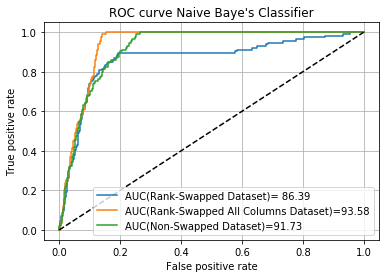

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((65769, 12339, 18, 96), (64719, 13389, 0, 114), (64846, 13262, 16, 98))

In [43]:
#Defining the classifier
cnb = ComplementNB()

#Fitting the data and making predictions.
y1_pred = cnb.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = cnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = cnb.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = cnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = cnb.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = cnb.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve Naive Baye's Classifier")
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### Logistic Regression

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 6426
accuracy:  0.9178491984352228
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 6680
accuracy:  0.9146020301194038
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 5833
accuracy:  0.9254301858812098


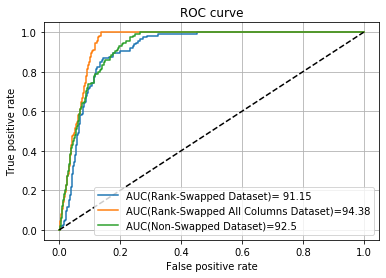

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((71724, 6384, 42, 72), (71457, 6651, 29, 85), (72317, 5791, 42, 72))

In [40]:
#Defining the classifier
clf =LogisticRegression(solver='lbfgs', max_iter=1000)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### Gradient Boosting Classifier. 

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 4314
accuracy:  0.9448492751399862
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 4982
accuracy:  0.9363094781519266
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 2626
accuracy:  0.9664288819002327


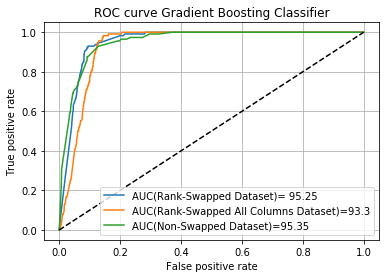

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((73832, 4276, 38, 76), (73183, 4925, 57, 57), (75530, 2578, 48, 66))

In [42]:
#Defining the classifier
clf = GradientBoostingClassifier(n_estimators=10)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Gradient Boosting Classifier')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### 3b. Performance Analysis and Explaination for Differences within the Classifiers.

#### Naive Baye's Classifier-

Here I've used the complement naive baye's classifier which as mentioned in the sklearn documentation treats every variable as having a multinomial distribution which is in agreement with the kind of variables we have in our dataset as they are mostly categorical in nature. Additionally, this classifier is also well suited for class imbalances as well. I would like to mention that this model correctly classified almost all positive cases of fraud(113/114) in the test set for the (all-columns) rank-swapped dataset. However this comes at the cost of too many false positives(13375) as well which is expected as this classifier has a high bias in general due to it's strong("naive") probabilistic assumptions about features being independent. 
Furthermore, for this classifier, we see that the area under the ROC curve is highest for the dataset with all the columns being rank-swapped(93.64%). These results were quite surprising initially but I believe that this result can be explained by the fact that re-ordering all columns instead of just the few ordinal columns makes the entire dataset a bit more homogenous as compared to performing rank-swapping for just the ordinal ones, making it less noisy and perhaps making it easier for the model to learn as well. In terms of accuracy, we actually see that rank-swapped data with just the ordinal columns being swapped does best but we know that accuracy is a misleading metric when it comes to such an imbalanced dataset. Lastly, we see that the overall performance of this classifier as compared to the rest is quite poor.  

#### Logistic Classifier-

Stepping into a stronger classifier, the logistic classifier maximizes the data likelihood(assuming data points are I.I.D) to choose the best set of parameters for the model using the gradient descent method. And so I've set max_iter to be 1000 for it to converge to the correct parameter settings. This model has been known to work well for binary classification problems in practice as it assumes the labels to follow a bernoulli distribution(binary labels i.e Fraud or Not) and doesn't make strict probabilistic assumptions as mentioned previously(has less bias basically). Indeed, we see that it already does considerably better than the naive baye's classifier which is expected. Here we see that the ROC curve is similarly best for rank-swapping the entire dataset as well(94.52%). We also observe that for the (all-columns) rank-swapped dataset, it is able to correctly classify 88 out of 114 cases of fraud but with 6301 false positives which is much lesser than the previous classifier(less than half!). In terms of accuracy, we see that it's better than Naive Baye's ofcourse and we also see that the dataset which contains no rankswapping actually attains the best accuracy in this case which is closely followed by the dataset on which we only rank-swap ordinal columns.  

#### Gradient Boosting Classifier-
Last but definitely not the least, I've used the Gradient Boosting Classifier which is an ensemble model meaning that it comprises of multiple weak learners to finally output a good prediction. This type of classifier relies on decision trees which are incrementally added over time and whose parameters are adjusted based on similar gradient descent optimization techniques which aim to minimize the error or overall loss of the model. This model actually outperforms both the previous classifiers in terms of accuracy and has the overall highest area under the ROC curve. Furthermore we see that, it is able to correctly classify 73 out of 114 cases of fraud in the test set and does so with the least number of false positives(3693) on the ranked-swapped data. Unlike previous classifiers, we see that the highest AUC is not for the all-columns ranked swapped dataset but the dataset where we only rank-swap ordinal columns(95.01). I do not yet have an explanation for this to be frank. But I suspect that this model is much more flexible(higher variance and lesser bias) than the previous models and so is able to get distubred more easily by all-columns being rank swapped thereby slightly hurting performance as compared to the other models. 


*Kindly note that the values mentioned here will change slightly based on running the code again*

### 3c. Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

Based on my results, I would say that performing rank swapping doesn't seem to hurt performance at all. Infact, I see that it sometimes results in a higher area under the ROC curve. Hence, based on my results I believe rank swapping is a good overall method for protecting people's privacy as it still allows researchers to use the data effectively without comprising on ethical concerns of privacy by disordering and thereby masking particularly sensitive personal information for a given row. In addition it's relatively easy to implement and can be used independently on different columns of the dataset. Furthermore, the fact that the user can also adjust the percentage of total rows for which two ranked values in a column can be swapped makes it possible to better suit the needs of a wide variety of datasets. Lastly, we also see that with the percentage set to 10% as I have, even sub sampling the data randomly didn't destroy the multi-variate statistics of the sampled data and the same also goes for the number of columns being rank-swapped. (*I'm basing this purely on my results obtained from the different classifiers*). 